# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [ ]:
#Importing the fastai library
from fastai.vision import *

#Updating the library
!curl -s https://course.fast.ai/setup/colab | bash

#Setting our working direction
#We need that to download our own dataset of images from the .csv files 
#with URLs stored on the Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Projects/'

Updating fastai...
Done.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
#storing the names of the folders with .csv files containing URLs to images
folders = ['Adidas_NMD','Adidas_Yeezy_Boost_350', 'Converse_Chuck_Taylor_All_Star', 
           'Fila_Disruptor', 'New_Balance_574', 'Nike_Air_Force_1', 'Nike_Air_Jordan_1', 
           'Nike_Air_Jordan_11', 'Nike_Air_Max_90', 'Nike_Air_Max_Plus_Tn', 'Nike_Cortez', 
           'Nike_Huarache', 'Nike_Vapor_Max', 'Reebok_Classic_Leather', 'Vans']

#creating a copy list which will be used to store the files' names
files = folders.copy()

#changing the names of the folders to files by adding .csv 
#it is because originally I have saved all the files to have the same name format
#now, we can take advantage of it and automate the process
for i in range(len(files)):
    files[i]=files[i]+str('.csv')

for i in range(len(folders)):
  #defining a path and a destination to the .csv image we want to access
  path = Path(base_dir + 'data/Kicks')
  dest = path/folders[i]
  dest.mkdir(parents=True, exist_ok=True)
  #downloading the images from the .csv file, using fastai's built-in function 
  download_images(dest/files[i], dest, max_pics=200)


In [ ]:
#Next, we can remove any images that can't be opened:
for shoe in folders:
    print(shoe)
    verify_images(dest/shoe, delete=True, max_size=500)

Adidas_NMD
Adidas_Yeezy_Boost_350
Converse_Chuck_Taylor_All_Star
Fila_Disruptor
New_Balance_574
Nike_Air_Force_1
Nike_Air_Jordan_1
Nike_Air_Jordan_11
Nike_Air_Max_90
Nike_Air_Max_Plus_Tn
Nike_Cortez
Nike_Huarache
Nike_Vapor_Max
Reebok_Classic_Leather
Vans


## View data

In [ ]:
#setting a seed for reproducibility
np.random.seed(1)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [ ]:
data.classes

['Adidas_NMD',
 'Adidas_Yeezy_Boost_350',
 'Converse_Chuck_Taylor_All_Star',
 'Fila_Disruptor',
 'New_Balance_574',
 'Nike_Air_Force_1',
 'Nike_Air_Jordan_1',
 'Nike_Air_Jordan_11',
 'Nike_Air_Max_90',
 'Nike_Air_Max_Plus_Tn',
 'Nike_Cortez',
 'Nike_Huarache',
 'Nike_Vapor_Max',
 'Reebok_Classic_Leather',
 'Vans']

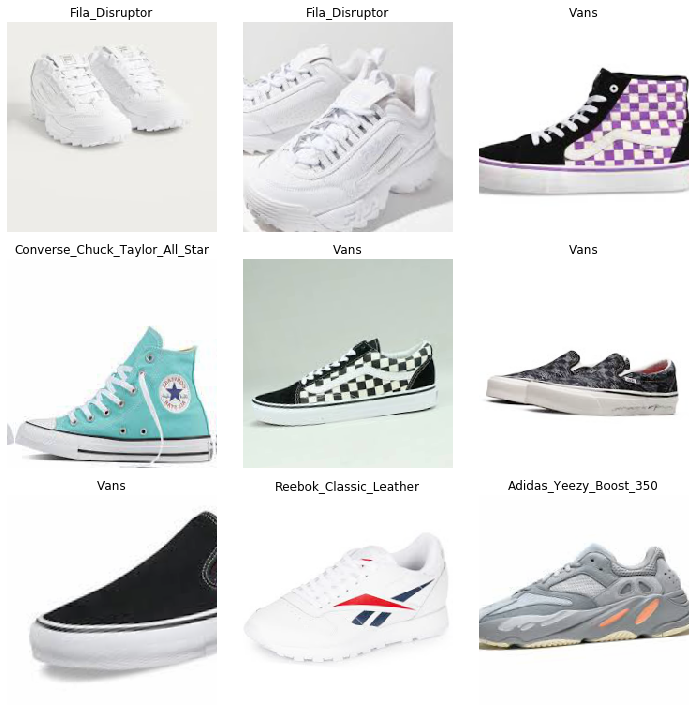

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Adidas_NMD',
  'Adidas_Yeezy_Boost_350',
  'Converse_Chuck_Taylor_All_Star',
  'Fila_Disruptor',
  'New_Balance_574',
  'Nike_Air_Force_1',
  'Nike_Air_Jordan_1',
  'Nike_Air_Jordan_11',
  'Nike_Air_Max_90',
  'Nike_Air_Max_Plus_Tn',
  'Nike_Cortez',
  'Nike_Huarache',
  'Nike_Vapor_Max',
  'Reebok_Classic_Leather',
  'Vans'],
 15,
 2022,
 505)

## Train model

In [ ]:
#creating a cnn
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#running one fitting cycle of the neural network
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.179185,1.269810,0.372277,00:22
1,2.050478,1.018265,0.304951,00:22
2,1.503929,0.859251,0.253465,00:22
3,1.203244,0.840293,0.241584,00:22


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


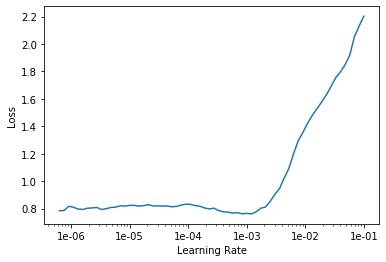

In [ ]:
#We can plot our learning rate
#at the plot we look at the steepest descending gradient to run the next learning cycle
#with a learning rate between these values
learn.recorder.plot()

In [ ]:
#In our case, there is no steep fall of the learning rate anywhere on the plot.
#However, we will choose the rate between le-04 and le-03 as there seems to be
#at least some decrease
learn.fit_one_cycle(3, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.128071,4.247422,0.477228,00:23
1,0.944456,0.612986,0.176238,00:23
2,0.646575,0.402884,0.100990,00:23


In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
#We have an image classification problem and so we can use the 
#ClassificationInterpretation class
interp = ClassificationInterpretation.from_learner(learn)

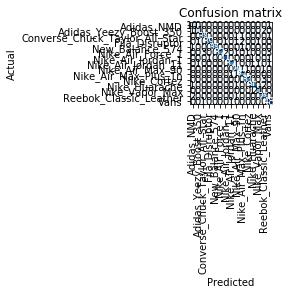

In [ ]:
#displaying a confusion matrix
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class